In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv("AER_credit_card_data.csv")

## Create target variable

In [42]:
df['card'] = df['card'].replace({"yes":1,"no":0})

## Train test split

In [43]:
df_full_train , df_test = train_test_split(df , test_size = 0.2 , random_state= 1)

In [44]:
df_train , df_val = train_test_split(df_full_train , test_size = 0.25 , random_state= 1)

In [45]:
y_full_train = df_full_train['card']
y_train = df_train['card']
y_test = df_test['card']
y_val = df_val['card']

In [46]:
del df_full_train['card']
del df_test['card']
del df_train['card']
del df_val['card']

In [47]:
numerical = ['reports',
'dependents',
'active',
'share']

## Question 1

In [83]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print((col, auc))

('reports', 0.7166629860689376)
('dependents', 0.5327757227773791)
('active', 0.6043173411362006)
('share', 0.989183643423692)


## Question 2

In [170]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [171]:
train_dicts = df_train[columns].to_dict(orient = 'records')
dv = DictVectorizer(sparse= False)
X_train = dv.fit_transform(train_dicts)

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train,y_train)

val_dicts = df_val[columns].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

/home/book/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [172]:
round(roc_auc_score(y_val, y_pred),3)

0.995

## Question 3

In [174]:
def tpr_fpr_dataframe(y_val,y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    

    return df_scores

In [175]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [176]:
df_scores['pre'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['rec'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000
2,0.02,211,30,0,23,1.000000,0.566038,0.875519,1.000000
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000
...,...,...,...,...,...,...,...,...,...
96,0.96,203,0,8,53,0.962085,0.000000,1.000000,0.962085
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346


In [177]:
df_scores[df_scores['pre'] == df_scores['rec']]

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec
20,0.20,206,5,5,48,0.976303,0.09434,0.976303,0.976303
21,0.21,206,5,5,48,0.976303,0.09434,0.976303,0.976303
22,0.22,206,5,5,48,0.976303,0.09434,0.976303,0.976303
23,0.23,206,5,5,48,0.976303,0.09434,0.976303,0.976303
24,0.24,206,5,5,48,0.976303,0.09434,0.976303,0.976303
25,0.25,206,5,5,48,0.976303,0.09434,0.976303,0.976303
26,0.26,206,5,5,48,0.976303,0.09434,0.976303,0.976303


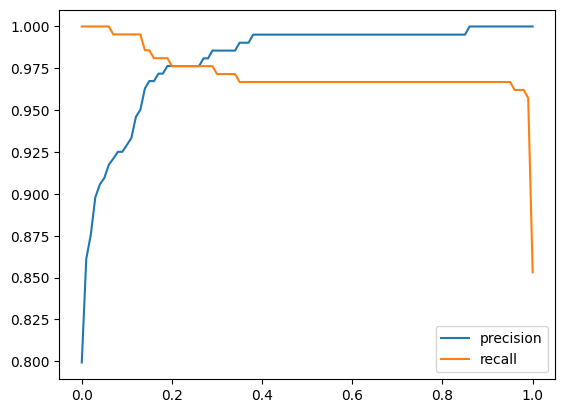

In [178]:
plt.plot(df_scores.thresholds, df_scores.pre, label='precision')
plt.plot(df_scores.thresholds, df_scores.rec, label='recall')

plt.legend()
plt.show()

## Question 4

In [179]:
df_scores['f1'] = 2 * df_scores['pre'] * df_scores['rec']/(df_scores['pre'] + df_scores['rec'])

In [180]:
df_scores

,thresholds,tp,fp,fn,tn,tpr,fpr,pre,rec,f1
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000,0.925439
2,0.02,211,30,0,23,1.000000,0.566038,0.875519,1.000000,0.933628
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...,...,...
96,0.96,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346,0.978208


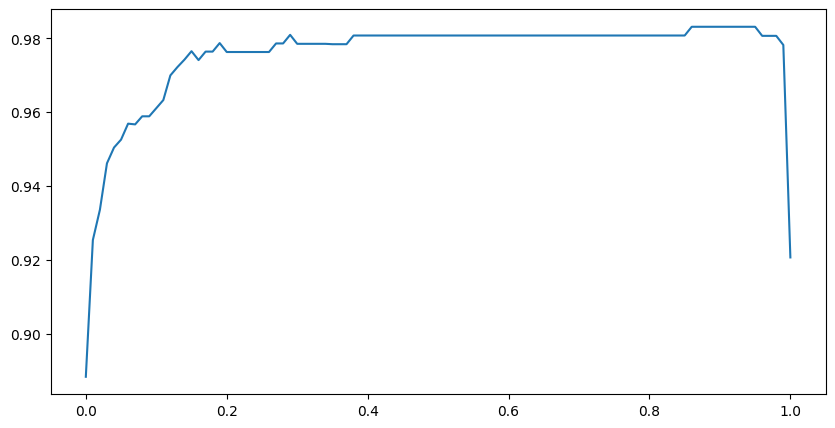

In [181]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.thresholds, df_scores.f1)

In [182]:
df_scores.iloc[df_scores.f1.idxmax()]

thresholds      0.860000
tp            204.000000
fp              0.000000
fn              7.000000
tn             53.000000
tpr             0.966825
fpr             0.000000
pre             1.000000
rec             0.966825
f1              0.983133
Name: 86, dtype: float64